In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import geopandas
import cartopy.io.shapereader as shpreader
import shapely
import re

from matplotlib.patches import Rectangle


# Load all the data

In [ ]:
degrees = 2.5
tdf = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

tdf['temperature_da'] = tdf['da_trend_cells']
pdf['precip_da'] = tdf['da_trend_cells']

dadf = tdf[['id','temperature_da']].merge(pdf[['id','precip_da']], how="outer").fillna(0)

# How many gridcells of the paper contain a D&A trend
dadf['da'] = np.max(dadf[['temperature_da','precip_da']],axis=1)
dadf = dadf[['id','da']]

dadf.head()

In [ ]:
cat_df = pd.read_csv('../data/1_predicted_category_documents.csv')
predictions = pd.read_csv('../data/1_document_relevance.csv')
df = dadf.merge(cat_df.merge(predictions), how="outer")

# Merge actual and predicted categories
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction",
    "12 - Total"
]

# Merge actual and predicted specific categories

extra_cat_df = pd.read_csv('../data/1_predicted_category_documents_specific.csv')

specific_impact_cats = [x for x in extra_cat_df.columns if "18 -" in x and "mean" in x]

extra_cat_df = extra_cat_df[["id"]+[x for x in extra_cat_df.columns if "18 - " in x] ]

df = df.merge(extra_cat_df, how="outer")

print(df.shape)

import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])

impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1

specific_impacts = [
    '18 - Terrestrial Water Cycle - mean_prediction',
    '18 - Drought & Floods - mean_prediction',
    '18 - Cryosphere - mean_prediction',
    '18 - Coastal and marine Ecosystems - mean_prediction',
    '18 - Terrestrial ES - mean_prediction',
    #'18 - Carbon Cycle - mean_prediction',
    '18 - Wildfires - mean_prediction',
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
    #'18 - Other anthropogenic - mean_prediction'
]

for c in specific_impacts:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    cs = [c, c.replace('mean_prediction','lower_pred'), c.replace('mean_prediction','upper_pred')]
    df.loc[df[label]==1,cs] = 1
    print(df[c].sum())

# Merge actual and predicted relevance
pcols = [
    '0 - relevance - mean_prediction',
    '0 - relevance - lower_pred',
    '0 - relevance - upper_pred'
]

df.loc[df['relevant']==1,pcols]=1

In [49]:
len(specific_impacts)

10

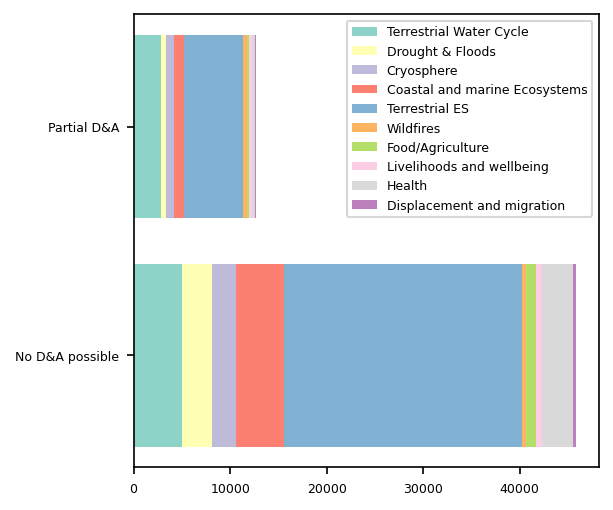

In [166]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

df['partially_attributed'] = np.where(df['da']>0,1,0)

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']

for i, (name, group) in enumerate(df.groupby('partially_attributed')):
    left=0
    for j, c in enumerate(specific_impacts):
        mid = group[
            (group['0 - relevance - mean_prediction']>0.5) & 
            (group[c]>0.5)
        ].shape[0]
        if i!=0:
            label=c.split(' - ')[1]
        else:
            label=None
        ax.barh(i, mid, left=left, label=label, color=colors[j])
        left+=mid
    #ax.barh(i, group.shape)
ax.legend(fontsize=6)

ax.set_yticks([0,1])
ax.set_yticklabels(["No D&A possible", "Partial D&A"])

ax.tick_params(axis='both', labelsize=6) 


In [37]:
doc_continents = pd.read_csv('../data/doc_continents.csv')
doc_continents.head()

,doc_id,continent
0,1340101,NaN
1,222401,North America
2,3307272,North America
3,355004,North America
4,4603,North America


In [55]:
doc_continents.groupby('continent').size().sort_values()

continent
South America     4500
Africa            6805
Oceania           7217
Europe           16458
Asia             22424
North America    28567
dtype: int64

,continent,attribution,impact,n
0,North America,No D&A Possible,Terrestrial Water Cycle,1749
1,North America,No D&A Possible,Drought & Floods,908
2,North America,No D&A Possible,Cryosphere,790
3,North America,No D&A Possible,Coastal and marine Ecosystems,1571
4,North America,No D&A Possible,Terrestrial ES,6607


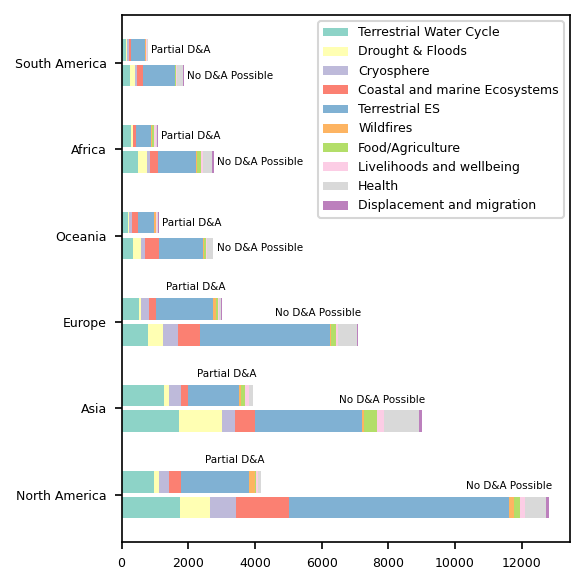

In [117]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

ticks = []

da_labels = ["No D&A Possible", "Partial D&A"]
da_spacing = [-0.3,+0.3]

data = []

continents = ["North America", "Asia", "Europe", "Oceania", "Africa", "South America"]
for h, continent in enumerate(continents):
    cgroup = doc_continents[doc_continents['continent']==continent]
    df_continent = df[df['id'].isin(cgroup['doc_id'])]
    for i, (name, group) in enumerate(df_continent.groupby('partially_attributed')):
        left=0
        ticks.append(f"{continent} - {da_labels[name]}")

        y = h*2+da_spacing[i]
        for j, c in enumerate(specific_impacts):
            mid = group[
                (group['0 - relevance - mean_prediction']>0.5) & 
                (group[c]>0.5)
            ].shape[0]
            if i==0 and h==0:
                label=c.split(' - ')[1]
            else:
                label=None
            ax.barh(y, mid, left=left, label=label, color=colors[j],height=0.5)
            
            data.append({
                "continent": continent,
                "attribution": da_labels[i],
                "impact": c.split(' - ')[1],
                "n": mid
            })
            
            
            left+=mid
            
        #ax.text(left+100, y, da_labels[i], fontsize=5, va="center")
        if left > 3000:
            ax.annotate(da_labels[i], (left+100, y+0.5), fontsize=5, va="center", ha="right")
        else:
            ax.annotate(da_labels[i], (left+100, y), fontsize=5, va="center", ha="left")
        #ax.barh(i, group.shape)
        
#         if h==0 and i==0:
#             ax.set_xlim(xmax=left+3500)
    ax.legend(fontsize=6)

# ax.set_yticks(range(1,len(ticks)+1))
# ax.set_yticklabels(ticks)
#ax.set_yticklabels(["No D&A possible", "Partial D&A"])
ax.set_yticks(np.arange(len(continents))*2)
ax.set_yticklabels(continents)
ax.tick_params(axis='both', labelsize=6) 

fig.tight_layout()

sum_df = pd.DataFrame.from_dict(data)
sum_df.head()

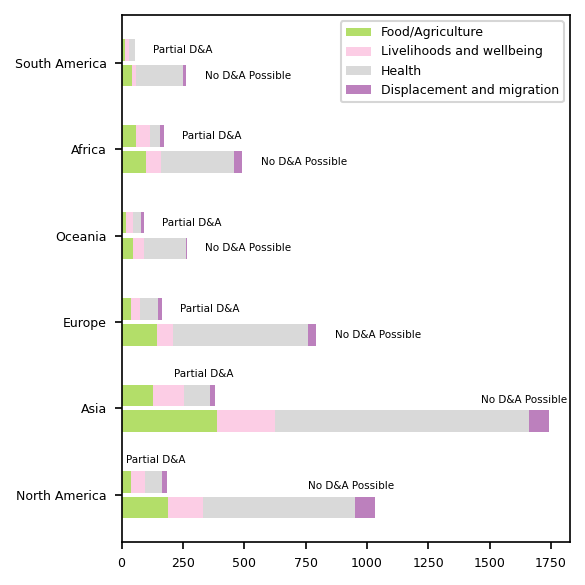

In [114]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)

ticks = []

da_labels = ["No D&A Possible", "Partial D&A"]
da_spacing = [-0.3,+0.3]

continents = ["North America", "Asia", "Europe", "Oceania", "Africa", "South America"]
position="above"
for h, continent in enumerate(continents):
    cgroup = doc_continents[doc_continents['continent']==continent]
    df_continent = df[df['id'].isin(cgroup['doc_id'])]
    for i, (name, group) in enumerate(df_continent.groupby('partially_attributed')):
        left=0
        ticks.append(f"{continent} - {da_labels[name]}")

        y = h*2+da_spacing[i]
        for j, c in enumerate(specific_impacts):
            if j < 6:
                continue
            mid = group[
                (group['0 - relevance - mean_prediction']>0.5) & 
                (group[c]>0.5)
            ].shape[0]
            if i==0 and h==0:
                label=c.split(' - ')[1]
            else:
                label=None
            ax.barh(y, mid, left=left, label=label, color=colors[j],height=0.5)
            
            
            left+=mid
            
        #ax.text(left+100, y, da_labels[i], fontsize=5, va="center")
        if h < 2:
            ax.annotate(da_labels[i], (left+75, y+0.5), fontsize=5, va="center", ha="right")
        else:
            ax.annotate(da_labels[i], (left+75, y), fontsize=5, va="center", ha="left")
    ax.legend(fontsize=6)

# ax.set_yticks(range(1,len(ticks)+1))
# ax.set_yticklabels(ticks)
#ax.set_yticklabels(["No D&A possible", "Partial D&A"])
ax.set_yticks(np.arange(len(continents))*2)
ax.set_yticklabels(continents)
ax.tick_params(axis='both', labelsize=6) 

fig.tight_layout()

In [119]:
sum_df.head()

,continent,attribution,impact,n
0,North America,No D&A Possible,Terrestrial Water Cycle,1749
1,North America,No D&A Possible,Drought & Floods,908
2,North America,No D&A Possible,Cryosphere,790
3,North America,No D&A Possible,Coastal and marine Ecosystems,1571
4,North America,No D&A Possible,Terrestrial ES,6607


In [122]:
sum_df['continent_da_prop'] = sum_df['n'] / sum_df.groupby(['continent','attribution'])['n'].transform('sum')
sum_df.head()

,continent,attribution,impact,n,continent_prop,continent_da_prop
0,North America,No D&A Possible,Terrestrial Water Cycle,1749,0.102858,0.136523
1,North America,No D&A Possible,Drought & Floods,908,0.053399,0.070877
2,North America,No D&A Possible,Cryosphere,790,0.046460,0.061666
3,North America,No D&A Possible,Coastal and marine Ecosystems,1571,0.092390,0.122629
4,North America,No D&A Possible,Terrestrial ES,6607,0.388556,0.515729


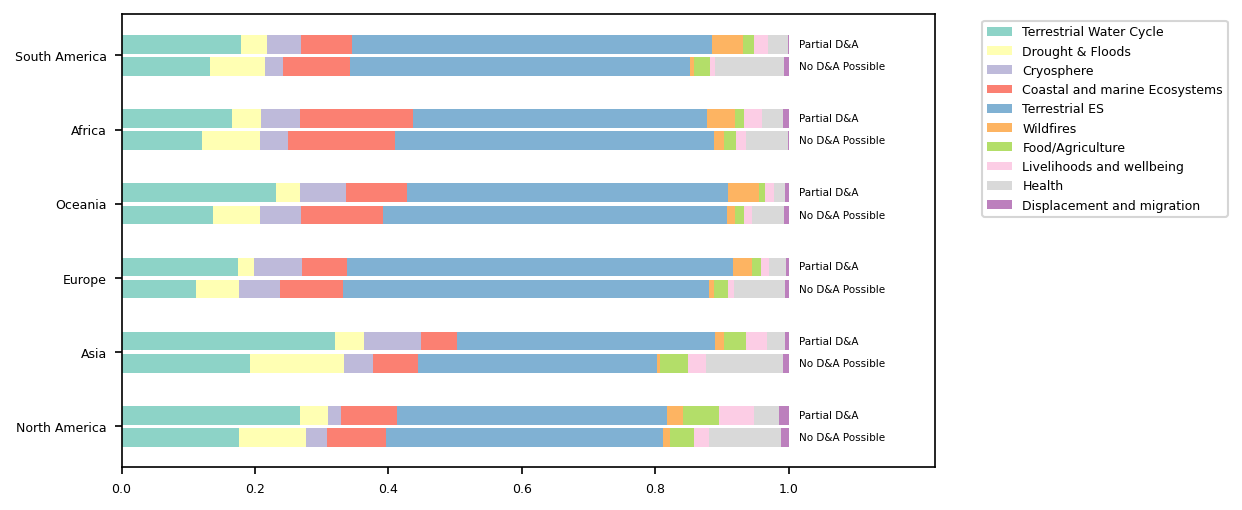

In [164]:
fig, ax = plt.subplots(figsize=(7,4), dpi=150)

for h, (continent, df_continent) in enumerate(sum_df.groupby('continent')):
    for i, (name, group) in enumerate(df_continent.groupby('attribution')):
        left=0

        y = h*2+da_spacing[i]
        for j, c in enumerate(specific_impacts):
            

            mid = group[group['impact']==c.split(' - ')[1]].continent_da_prop.values[0]
            if i==0 and h==0:
                label=c.split(' - ')[1]
            else:
                label=None
            ax.barh(y, mid, left=left, label=label, color=colors[j],height=0.5)
                 
            left+=mid
            
        ax.annotate(da_labels[i], (left+0.015, y), fontsize=5, va="center", ha="left")
        
ax.set_xlim(xmax=1.22)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
            
ax.legend(fontsize=6, bbox_to_anchor=(1.05,1))
ax.set_yticks(np.arange(len(continents))*2)
ax.set_yticklabels(continents)
ax.tick_params(axis='both', labelsize=6) 


In [151]:
c.split(' - ')[1]

'Terrestrial Water Cycle'

In [150]:
group

,continent,attribution,impact,n,continent_prop,continent_da_prop,continent_da_human_prop
80,Africa,No D&A Possible,Terrestrial Water Cycle,485,0.126335,0.175725,NaN
81,Africa,No D&A Possible,Drought & Floods,280,0.072936,0.101449,NaN
82,Africa,No D&A Possible,Cryosphere,83,0.021620,0.030072,NaN
83,Africa,No D&A Possible,Coastal and marine Ecosystems,245,0.063819,0.088768,NaN
84,Africa,No D&A Possible,Terrestrial ES,1147,0.298776,0.415580,NaN
85,Africa,No D&A Possible,Wildfires,28,0.007294,0.010145,NaN
86,Africa,No D&A Possible,Food/Agriculture,101,0.026309,0.036594,0.205285
87,Africa,No D&A Possible,Livelihoods and wellbeing,60,0.015629,0.021739,0.121951
88,Africa,No D&A Possible,Health,298,0.077624,0.107971,0.605691
89,Africa,No D&A Possible,Displacement and migration,33,0.008596,0.011957,0.067073


In [139]:
human_impacts = [    
    '18 - Food/Agriculture - mean_prediction',
    '18 - Livelihoods and wellbeing - mean_prediction',
    '18 - Health - mean_prediction',
    '18 - Displacement and migration - mean_prediction',
]
human_impacts = [x.split(' - ')[1] for x in human_impacts]
sum_df['continent_da_human_prop'] = sum_df['n'] / sum_df[sum_df['impact'].isin(human_impacts)].groupby(['continent','attribution'])['n'].transform('sum')
sum_df.head()

,continent,attribution,impact,n,continent_prop,continent_da_prop,continent_da_human_prop
0,North America,No D&A Possible,Terrestrial Water Cycle,1749,0.102858,0.136523,NaN
1,North America,No D&A Possible,Drought & Floods,908,0.053399,0.070877,NaN
2,North America,No D&A Possible,Cryosphere,790,0.046460,0.061666,NaN
3,North America,No D&A Possible,Coastal and marine Ecosystems,1571,0.092390,0.122629,NaN
4,North America,No D&A Possible,Terrestrial ES,6607,0.388556,0.515729,NaN


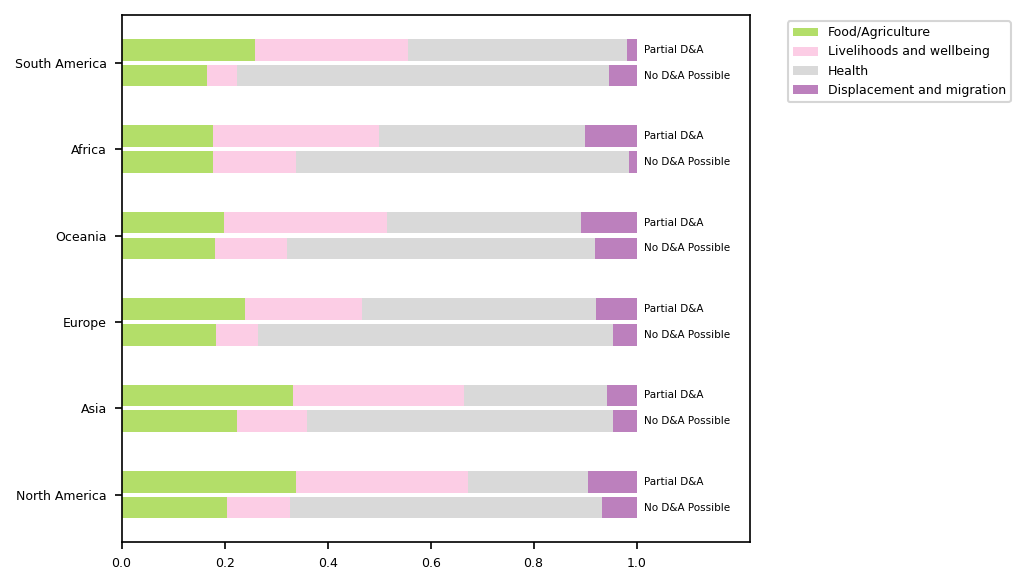

In [165]:
fig, ax = plt.subplots(figsize=(7,4), dpi=150)

for h, (continent, df_continent) in enumerate(sum_df.groupby('continent')):
    for i, (name, group) in enumerate(df_continent.groupby('attribution')):
        left=0

        y = h*2+da_spacing[i]
        for j, c in enumerate(specific_impacts):
            

            mid = group[group['impact']==c.split(' - ')[1]].continent_da_human_prop.values[0]
            if pd.isna(mid):
                continue
            if i==0 and h==0:
                label=c.split(' - ')[1]
            else:
                label=None
            ax.barh(y, mid, left=left, label=label, color=colors[j],height=0.5)
                 
            left+=mid
            
        ax.annotate(da_labels[i], (left+0.015, y), fontsize=5, va="center", ha="left")
        
ax.set_xlim(xmax=1.22)
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
            
ax.legend(fontsize=6, bbox_to_anchor=(1.05,1))
ax.set_yticks(np.arange(len(continents))*2)
ax.set_yticklabels(continents)
ax.tick_params(axis='both', labelsize=6) 

fig.tight_layout()
